In [1]:
# Slidin' Videos: Use high-precision text tracking and semantic segmentation for chapters generation

#### Please register for the Slidin' Videos challenge to get download URLs used in this notebook 

## 1. Deeplab finetuning
#### DeepLabV3 model is a pretrained model for semantic segmentation of images. We will finetune it on Slidin' Videos dataset of slide titles

# !git clone https://github.com/msminhas93/DeepLabv3FineTuning.git
!pip install -q torch torchvision pandas scikit-learn
!pip install -q opencv-python-headless Shapely Pillow easyocr


In [2]:
# !pip install -q Pillow==6.2.2

In [3]:
# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
!cp -r /kaggle/input/getdata/* /kaggle/working/

In [5]:
!ls

DeepLabv3FineTuning		    Test.zip		       __output__.json
SampleSubmission.csv		    Train.csv		       __results__.html
SlidinVideos_StarterNotebook.ipynb  Train.zip		       custom.css
Submission_fcn_resnet50.csv	    __notebook__.ipynb	       state.db
Test				    __notebook_source__.ipynb


In [6]:
#### Download title masks collection and unzip it to the cloned repository. 

# !unzip -q Train.zip -d DeepLabv3FineTuning/

In [7]:
!ls DeepLabv3FineTuning

Analysis.ipynb	README.md		       datahandler.py	 segdataset.py
CFExp		SegmentationDatasetDemo.ipynb  environment.yml	 trainer.py
CrackForest	Tests			       main.py
DemoExp		Train			       model.py
LICENSE.md	__pycache__		       requirements.txt


In [8]:
# !mkdir DeepLabv3FineTuning/Train

In [9]:
# !mv DeepLabv3FineTuning/Images DeepLabv3FineTuning/Train
# !mv DeepLabv3FineTuning/Masks DeepLabv3FineTuning/Train

In [10]:
#### Training DeepLab model: our goal is to maximize test_f1_score
#### You may want to play with number of epochs, learning rate and loss function to get better results

%cd DeepLabv3FineTuning
from pathlib import Path

#from segmentation_models_pytorch.losses.jaccard  import JaccardLoss
#from segmentation_models_pytorch.losses.constants import BINARY_MODE
#criterion = JaccardLoss(mode=BINARY_MODE)

import torch
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils import data

import datahandler
from model import createDeepLabv3
from trainer import train_model

/kaggle/working/DeepLabv3FineTuning


In [11]:
""" FCN Model download and change the head for your prediction"""
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

from torchvision.models.segmentation import FCN_ResNet50_Weights, DeepLabV3_ResNet101_Weights
from torchvision import models

def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head

    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.

    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True,
                                                   weights = DeepLabV3_ResNet101_Weights.DEFAULT
                                                   )
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

def createFCN(outputchannels=1):
    """FCN class with custom head

    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.

    Returns:
        model: Returns the DeepLabv3 model with the ResNet50 backbone.
    """
    model = models.segmentation.fcn_resnet50(pretrained=True,
                                                    progress=True,
                                             weights=FCN_ResNet50_Weights.DEFAULT
                                             )
    model.classifier = FCNHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [12]:
# Create the deeplabv3 resnet101 model which is pretrained on a subset
# of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
model = createDeepLabv3()
model.train()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 152MB/s]  


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [13]:
from pathlib import Path

from torch.utils.data import DataLoader
from torchvision import transforms

from segdataset import SegmentationDataset
import multiprocessing
pool = multiprocessing.Pool()


def get_dataloader_sep_folder(data_dir: str,
                              image_folder: str = 'Image',
                              mask_folder: str = 'Mask',
                              batch_size: int = 4):
    """ Create Train and Test dataloaders from two
        separate Train and Test folders.
        The directory structure should be as follows.
        data_dir
        --Train
        ------Image
        ---------Image1
        ---------ImageN
        ------Mask
        ---------Mask1
        ---------MaskN
        --Test
        ------Image
        ---------Image1
        ---------ImageM
        ------Mask
        ---------Mask1
        ---------MaskM

    Args:
        data_dir (str): The data directory or root.
        image_folder (str, optional): Image folder name. Defaults to 'Image'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Mask'.
        batch_size (int, optional): Batch size of the dataloader. Defaults to 4.

    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """
    data_transforms = transforms.Compose([transforms.ToTensor()])

    image_datasets = {
        x: SegmentationDataset(root=Path(data_dir) / x,
                               transforms=data_transforms,
                               image_folder=image_folder,
                               mask_folder=mask_folder)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=pool._processes)
        for x in ['Train', 'Test']
    }
    return dataloaders


def get_dataloader_single_folder(data_dir: str,
                                 image_folder: str = 'Images',
                                 mask_folder: str = 'Masks',
                                 fraction: float = 0.2,
                                 batch_size: int = 4):
    """Create train and test dataloader from a single directory containing
    the image and mask folders.

    Args:
        data_dir (str): Data directory path or root
        image_folder (str, optional): Image folder name. Defaults to 'Images'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Masks'.
        fraction (float, optional): Fraction of Test set. Defaults to 0.2.
        batch_size (int, optional): Dataloader batch size. Defaults to 4.

    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """
    data_transforms = transforms.Compose([transforms.ToTensor()])

    image_datasets = {
        x: SegmentationDataset(data_dir,
                               image_folder=image_folder,
                               mask_folder=mask_folder,
                               seed=100,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=pool._processes)
        for x in ['Train', 'Test']
    }
    return dataloaders

In [14]:
datahandler.get_dataloader_single_folder = get_dataloader_single_folder

In [15]:
data_directory = Path("Train")
# Create the experiment directory if not present
exp_directory = Path("DemoExp")
if not exp_directory.exists():
    exp_directory.mkdir()

epochs = 30

# Specify the evaluation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

# Create the dataloader
dataloaders = datahandler.get_dataloader_single_folder(
    data_directory, fraction=0.2, image_folder="Images", 
    mask_folder="Masks", batch_size=4)



# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')

# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
_ = train_model(model, 
                criterion,
                dataloaders,
                optimizer,
                bpath=exp_directory,
                metrics=metrics,
                num_epochs=epochs)


Epoch 1/30
----------


100%|██████████| 427/427 [14:08<00:00,  1.99s/it]


Train Loss: 0.0106


100%|██████████| 107/107 [01:50<00:00,  1.03s/it]

Test Loss: 0.0178
{'epoch': 1, 'Train_loss': 0.010639609768986702, 'Test_loss': 0.017779087647795677, 'Train_f1_score': 0.510233724885319, 'Train_auroc': 0.9630779554880994, 'Test_f1_score': 0.5974803527312504, 'Test_auroc': 0.9814751379701495}
Epoch 2/30
----------



100%|██████████| 427/427 [13:55<00:00,  1.96s/it]


Train Loss: 0.0098


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0034
{'epoch': 2, 'Train_loss': 0.009762518107891083, 'Test_loss': 0.003440470201894641, 'Train_f1_score': 0.6995265303342388, 'Train_auroc': 0.9897115173662177, 'Test_f1_score': 0.7327338637602838, 'Test_auroc': 0.9820327644365721}
Epoch 3/30
----------



100%|██████████| 427/427 [13:54<00:00,  1.96s/it]


Train Loss: 0.0128


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0031
{'epoch': 3, 'Train_loss': 0.012813491746783257, 'Test_loss': 0.0031090888660401106, 'Train_f1_score': 0.7434339336516173, 'Train_auroc': 0.9911705260670802, 'Test_f1_score': 0.7631883826295544, 'Test_auroc': 0.9761600124734577}
Epoch 4/30
----------



100%|██████████| 427/427 [13:53<00:00,  1.95s/it]


Train Loss: 0.0039


100%|██████████| 107/107 [01:47<00:00,  1.00s/it]

Test Loss: 0.0046
{'epoch': 4, 'Train_loss': 0.003946508746594191, 'Test_loss': 0.004576215986162424, 'Train_f1_score': 0.7603213021190265, 'Train_auroc': 0.9913981943136909, 'Test_f1_score': 0.7497418636038307, 'Test_auroc': 0.9830924080557373}
Epoch 5/30
----------



100%|██████████| 427/427 [13:55<00:00,  1.96s/it]


Train Loss: 0.0265


100%|██████████| 107/107 [01:47<00:00,  1.01s/it]

Test Loss: 0.0119
{'epoch': 5, 'Train_loss': 0.026508314535021782, 'Test_loss': 0.01190742664039135, 'Train_f1_score': 0.7979881332518935, 'Train_auroc': 0.9932786619626003, 'Test_f1_score': 0.7243534558051208, 'Test_auroc': 0.9812441366868266}
Epoch 6/30
----------



100%|██████████| 427/427 [13:51<00:00,  1.95s/it]


Train Loss: 0.0117


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0043
{'epoch': 6, 'Train_loss': 0.011737339198589325, 'Test_loss': 0.004276161547750235, 'Train_f1_score': 0.7812121892295131, 'Train_auroc': 0.9923032857794485, 'Test_f1_score': 0.7809043746869603, 'Test_auroc': 0.9788929114790806}
Epoch 7/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0046


100%|██████████| 107/107 [01:47<00:00,  1.01s/it]

Test Loss: 0.0028
{'epoch': 7, 'Train_loss': 0.004623426590114832, 'Test_loss': 0.002788103185594082, 'Train_f1_score': 0.8139462625058017, 'Train_auroc': 0.9941150963954243, 'Test_f1_score': 0.7471992814930155, 'Test_auroc': 0.9820832900395641}
Epoch 8/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0047


100%|██████████| 107/107 [01:47<00:00,  1.01s/it]

Test Loss: 0.0079
{'epoch': 8, 'Train_loss': 0.004713461734354496, 'Test_loss': 0.007878381758928299, 'Train_f1_score': 0.8265943596476063, 'Train_auroc': 0.9940229046928067, 'Test_f1_score': 0.7839657057016979, 'Test_auroc': 0.981271719010995}
Epoch 9/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0029


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0099
{'epoch': 9, 'Train_loss': 0.0028883509803563356, 'Test_loss': 0.009867173619568348, 'Train_f1_score': 0.8385486824848245, 'Train_auroc': 0.9945207416534124, 'Test_f1_score': 0.7753141584933159, 'Test_auroc': 0.9736941903137623}
Epoch 10/30
----------



100%|██████████| 427/427 [13:51<00:00,  1.95s/it]


Train Loss: 0.0039


100%|██████████| 107/107 [01:47<00:00,  1.01s/it]

Test Loss: 0.0140
{'epoch': 10, 'Train_loss': 0.003926112316548824, 'Test_loss': 0.013986289501190186, 'Train_f1_score': 0.8386747723301059, 'Train_auroc': 0.9946150344969434, 'Test_f1_score': 0.7962124243717258, 'Test_auroc': 0.9818135716417494}
Epoch 11/30
----------



100%|██████████| 427/427 [13:50<00:00,  1.95s/it]


Train Loss: 0.0025


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0033
{'epoch': 11, 'Train_loss': 0.00253414548933506, 'Test_loss': 0.0032569454051554203, 'Train_f1_score': 0.8316425253007061, 'Train_auroc': 0.9944793057525111, 'Test_f1_score': 0.806031083244392, 'Test_auroc': 0.9789840597286215}
Epoch 12/30
----------



100%|██████████| 427/427 [13:54<00:00,  1.95s/it]


Train Loss: 0.0043


100%|██████████| 107/107 [01:48<00:00,  1.02s/it]

Test Loss: 0.0056
{'epoch': 12, 'Train_loss': 0.004348753951489925, 'Test_loss': 0.005595491733402014, 'Train_f1_score': 0.8557125764050424, 'Train_auroc': 0.9951594170682478, 'Test_f1_score': 0.7799004097383012, 'Test_auroc': 0.9807244677154299}
Epoch 13/30
----------



100%|██████████| 427/427 [13:56<00:00,  1.96s/it]


Train Loss: 0.0036


100%|██████████| 107/107 [01:50<00:00,  1.03s/it]

Test Loss: 0.0119
{'epoch': 13, 'Train_loss': 0.0036430738400667906, 'Test_loss': 0.011937492527067661, 'Train_f1_score': 0.8657556822585782, 'Train_auroc': 0.9953896513657816, 'Test_f1_score': 0.7888920440396033, 'Test_auroc': 0.9700823966438451}
Epoch 14/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0041


100%|██████████| 107/107 [01:49<00:00,  1.02s/it]

Test Loss: 0.0238
{'epoch': 14, 'Train_loss': 0.004105346743017435, 'Test_loss': 0.023774927482008934, 'Train_f1_score': 0.8387927262675436, 'Train_auroc': 0.9945131745950013, 'Test_f1_score': 0.7872171254910527, 'Test_auroc': 0.9790308885972799}
Epoch 15/30
----------



100%|██████████| 427/427 [13:53<00:00,  1.95s/it]


Train Loss: 0.0035


100%|██████████| 107/107 [01:49<00:00,  1.02s/it]

Test Loss: 0.0077
{'epoch': 15, 'Train_loss': 0.0034668489824980497, 'Test_loss': 0.007697299588471651, 'Train_f1_score': 0.8571637230677498, 'Train_auroc': 0.9954542180467979, 'Test_f1_score': 0.8194803653831153, 'Test_auroc': 0.9771053028458131}
Epoch 16/30
----------



100%|██████████| 427/427 [13:53<00:00,  1.95s/it]


Train Loss: 0.0044


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0017
{'epoch': 16, 'Train_loss': 0.00438731350004673, 'Test_loss': 0.001723037799820304, 'Train_f1_score': 0.8636994730240257, 'Train_auroc': 0.9960142522933139, 'Test_f1_score': 0.7979298499085414, 'Test_auroc': 0.9782149704526008}
Epoch 17/30
----------



100%|██████████| 427/427 [13:55<00:00,  1.96s/it]


Train Loss: 0.0031


100%|██████████| 107/107 [01:47<00:00,  1.01s/it]

Test Loss: 0.0025
{'epoch': 17, 'Train_loss': 0.0031376276165246964, 'Test_loss': 0.0024682371877133846, 'Train_f1_score': 0.870878999284776, 'Train_auroc': 0.996187570343756, 'Test_f1_score': 0.823435930680713, 'Test_auroc': 0.9750661840449284}
Epoch 18/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0024


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0026
{'epoch': 18, 'Train_loss': 0.0024171066470444202, 'Test_loss': 0.0026206793263554573, 'Train_f1_score': 0.8781567239136722, 'Train_auroc': 0.9965354428623716, 'Test_f1_score': 0.8252054771444213, 'Test_auroc': 0.9778221376529074}
Epoch 19/30
----------



100%|██████████| 427/427 [13:51<00:00,  1.95s/it]


Train Loss: 0.0026


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0018
{'epoch': 19, 'Train_loss': 0.0026271259412169456, 'Test_loss': 0.0018292961176484823, 'Train_f1_score': 0.8839335608715874, 'Train_auroc': 0.9967805903591044, 'Test_f1_score': 0.8284927276767513, 'Test_auroc': 0.97893951414823}
Epoch 20/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0031


100%|██████████| 107/107 [01:47<00:00,  1.00s/it]

Test Loss: 0.0253
{'epoch': 20, 'Train_loss': 0.0030726157128810883, 'Test_loss': 0.025270435959100723, 'Train_f1_score': 0.8755296133075803, 'Train_auroc': 0.9965187374259742, 'Test_f1_score': 0.7511633516028778, 'Test_auroc': 0.9684337868027506}
Epoch 21/30
----------



100%|██████████| 427/427 [13:54<00:00,  1.95s/it]


Train Loss: 0.0021


100%|██████████| 107/107 [01:49<00:00,  1.03s/it]

Test Loss: 0.0065
{'epoch': 21, 'Train_loss': 0.0021327186841517687, 'Test_loss': 0.0065080272033810616, 'Train_f1_score': 0.8253818863342762, 'Train_auroc': 0.9936515157742991, 'Test_f1_score': 0.7317546535495013, 'Test_auroc': 0.9779228745636523}
Epoch 22/30
----------



100%|██████████| 427/427 [13:56<00:00,  1.96s/it]


Train Loss: 0.0046


100%|██████████| 107/107 [01:49<00:00,  1.02s/it]

Test Loss: 0.0020
{'epoch': 22, 'Train_loss': 0.004552538972347975, 'Test_loss': 0.0020003824029117823, 'Train_f1_score': 0.8643602155257526, 'Train_auroc': 0.9961214517222068, 'Test_f1_score': 0.8172655885742882, 'Test_auroc': 0.9732705399662684}
Epoch 23/30
----------



100%|██████████| 427/427 [13:55<00:00,  1.96s/it]


Train Loss: 0.0073


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0021
{'epoch': 23, 'Train_loss': 0.007280837744474411, 'Test_loss': 0.0020563744474202394, 'Train_f1_score': 0.8707228270623348, 'Train_auroc': 0.9964443652046227, 'Test_f1_score': 0.7974817433476414, 'Test_auroc': 0.975963021490003}
Epoch 24/30
----------



100%|██████████| 427/427 [13:53<00:00,  1.95s/it]


Train Loss: 0.0024


100%|██████████| 107/107 [01:49<00:00,  1.02s/it]

Test Loss: 0.0056
{'epoch': 24, 'Train_loss': 0.002369942609220743, 'Test_loss': 0.005555174313485622, 'Train_f1_score': 0.8588225178113861, 'Train_auroc': 0.9954000615641466, 'Test_f1_score': 0.8045032735496301, 'Test_auroc': 0.9780189387313851}
Epoch 25/30
----------



100%|██████████| 427/427 [13:54<00:00,  1.95s/it]


Train Loss: 0.0032


100%|██████████| 107/107 [01:50<00:00,  1.03s/it]

Test Loss: 0.0029
{'epoch': 25, 'Train_loss': 0.0032188817858695984, 'Test_loss': 0.0029470196459442377, 'Train_f1_score': 0.873208893372535, 'Train_auroc': 0.9963238913352847, 'Test_f1_score': 0.8232718562841811, 'Test_auroc': 0.9765980097145013}
Epoch 26/30
----------



100%|██████████| 427/427 [13:55<00:00,  1.96s/it]


Train Loss: 0.0020


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0024
{'epoch': 26, 'Train_loss': 0.0020376211032271385, 'Test_loss': 0.002418195828795433, 'Train_f1_score': 0.8850327914483825, 'Train_auroc': 0.9964697323494994, 'Test_f1_score': 0.824790292116159, 'Test_auroc': 0.9838235748877574}
Epoch 27/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0022


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0049
{'epoch': 27, 'Train_loss': 0.0022406631615012884, 'Test_loss': 0.004874418489634991, 'Train_f1_score': 0.8897283960262334, 'Train_auroc': 0.9968454044398691, 'Test_f1_score': 0.8176326985957841, 'Test_auroc': 0.9814046643937601}
Epoch 28/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0019


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]

Test Loss: 0.0059
{'epoch': 28, 'Train_loss': 0.0019227297743782401, 'Test_loss': 0.005927929654717445, 'Train_f1_score': 0.8886581985921983, 'Train_auroc': 0.9970979008152451, 'Test_f1_score': 0.8298040773069995, 'Test_auroc': 0.9827378799566783}
Epoch 29/30
----------



100%|██████████| 427/427 [13:51<00:00,  1.95s/it]


Train Loss: 0.0046


100%|██████████| 107/107 [01:49<00:00,  1.02s/it]

Test Loss: 0.0212
{'epoch': 29, 'Train_loss': 0.004561327863484621, 'Test_loss': 0.021189214661717415, 'Train_f1_score': 0.8827648689263342, 'Train_auroc': 0.9968318663438341, 'Test_f1_score': 0.8294190880438747, 'Test_auroc': 0.9808101581215759}
Epoch 30/30
----------



100%|██████████| 427/427 [13:52<00:00,  1.95s/it]


Train Loss: 0.0034


100%|██████████| 107/107 [01:49<00:00,  1.02s/it]

Test Loss: 0.0028
{'epoch': 30, 'Train_loss': 0.0033736603800207376, 'Test_loss': 0.002829400822520256, 'Train_f1_score': 0.8653707998445317, 'Train_auroc': 0.9960760102814692, 'Test_f1_score': 0.7753197349807825, 'Test_auroc': 0.974775135700745}
Training complete in 471m 51s
Lowest Loss: 0.001723


In [16]:

# Save the trained model
torch.save(model, exp_directory / 'weights.pt')

# Terminate
exit()
%cd ../


/kaggle/working


In [17]:
## 2. Making the submission
#### Unpack the testset
# !unzip -q Test.zip

In [18]:
!ls

DeepLabv3FineTuning		    Test.zip		       __output__.json
SampleSubmission.csv		    Train.csv		       __results__.html
SlidinVideos_StarterNotebook.ipynb  Train.zip		       custom.css
Submission_fcn_resnet50.csv	    __notebook__.ipynb	       state.db
Test				    __notebook_source__.ipynb


In [19]:
# !mkdir Test
# !mv Images/ Test/

In [1]:
#### Load finetuned deeplab model and define helper functions

import glob
import os
import json
import cv2    
import torch
import numpy as np
import pandas as pd

from torchvision import transforms  
from PIL import Image

deeplab_width = 768
deeplab_height = 432
deeplab = torch.load('DeepLabv3FineTuning/DemoExp/weights.pt')
deeplab.eval()
     

def boxify(out, boxes):
    return [ torch.mean(out[b[0]:b[1], b[2]:b[3]]).item()  for b in boxes ]      

def titlesegment(image, boxes):
    # Resize the frame to the training input size
    inputs = transforms.ToTensor()(Image.fromarray(image, mode="RGB"))
    inputs = inputs.reshape(1, *inputs.shape).to('cuda')
    
    with torch.set_grad_enabled(False):
        outputs = deeplab(inputs)
        out = outputs['out'][0][0]
        box_scores = boxify(out, boxes)
        return out, np.array(box_scores)
    
def occupation(boxes):
    area = lambda b: (b[1]-b[0]) * (b[3]-b[2])
    y1, y2 = min([b[0] for b in boxes ]), max([b[1] for b in boxes ])
    x1, x2 = min([b[2] for b in boxes ]), max([b[3] for b in boxes ])
    return 1.0 * sum([ area(b) for b in boxes ]) / area([y1, y2, x1, x2])

# Locates a paragraph of text with the highest probability 
# to be a slide title 
def pickonetitle(boxes, scores):
    if len(boxes) == 0:
        return []
        
    best_idx = np.argmax(scores)
    best = boxes[best_idx]

    candidates = { i for i, box in enumerate(boxes) 
        if abs(box['fontsize']-best['fontsize']) <= best['fontsize'] * 0.25 
            and scores[best_idx] - scores[i] < 0.6 }
    
    while occupation([ boxes[i]['bbox'] for i in candidates ]) < 0.75:
        combinations = [ candidates - {j} for j in candidates if j != best_idx ]
        candidates = max(combinations, 
            key=lambda comb: occupation([ boxes[j]['bbox'] for j in comb ]))
            
    title_boxes = [ boxes[i] for i in candidates ]
    return title_boxes    

#### Now, we're going to use EasyOCR package to "read" the titles. Modern OCR solutions may still produce a handful of errors, which is why you're encouraged to apply a language model or alternative OCR model to fix possible misspelings. 

from shapely.geometry import Polygon, LineString

import easyocr
reader = easyocr.Reader(['en']) 

def sameline(a, b):
    return ((min(a['bbox'][1], b['bbox'][1]) - max(a['bbox'][0], b['bbox'][0]))
            / min(a['height'], b['height'])) >= 0.8
            
def isbelow(a, b):
    return not sameline(a, b) and a['bbox'][0] > b['bbox'][0]  
    
def isright(a, b):
    return sameline(a, b) and a['bbox'][2] > b['bbox'][2]  

def sort_boxes(boxes):              
    boxes_ = []
    for b in boxes:
        i = 0
        while i < len(boxes_) and (isbelow(b, boxes_[i]) or isright(b, boxes_[i])):
            i += 1
        boxes_.insert(i, b)
    return boxes_

def _norm_bbox(bbox):
    return  [ int(max(0, min([ p[1] for p in bbox ]))), 
              int(max([ p[1] for p in bbox ])), 
              int(max(0, min([ p[0] for p in bbox ]))), 
              int(max([ p[0] for p in bbox ])) ]

def process_ocr(ocr_results):
    items = []
    for bbox, text, conf in ocr_results:
        if text == '' or conf <= 0:
            continue  
        if not isinstance(bbox, list):
            bbox = bbox.tolist()
        item = {}
        item['width'] = LineString(bbox[0:2]).length
        item['height'] = LineString(bbox[1:3]).length
        item['area'] = item['width'] * item['height']
        item['fontsize'] = 1.0 * item['width'] / len(text)
        item['bbox'] = _norm_bbox(bbox)            
        item['text'] = text
        item['conf'] = float(conf)
        items.append(item)
    return items     

def read_text(img):
    return process_ocr(reader.readtext(img))

### Data exploration
#### First, we will pick some random test slide and will extract any instance of text on it

from IPython.display import display, JSON, Image as IImage

def draw_boxes(frame, boxes):
    for box in boxes:
        frame = cv2.rectangle(frame, (box[2], box[0]), (box[3], box[1]), (36,255,12), 2)
    return frame

In [2]:
!ls Test/Images/*33.jpg

Test/Images/Id_76dbm25833.jpg


In [3]:
!ls Test/Images/*.jpg | wc -l

290


In [4]:
# !ls Test/Images/*.jpg | head -n 5

In [5]:
import re
''.join(re.findall(r'\d+', "Id_0khgx7z8tk.jpg"))

'078'

'Test slide #33'

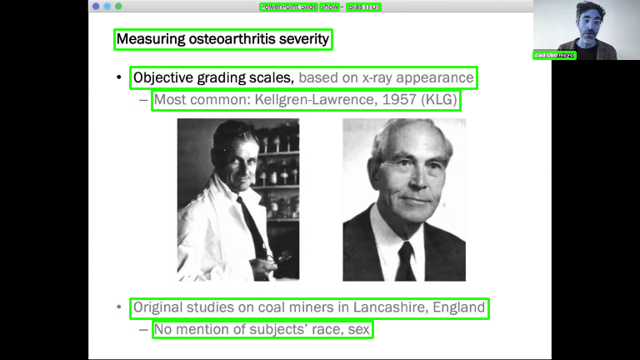

,width,height,area,fontsize,bbox,text
0,68.0,8.0,544.0,4.250000,"[4, 12, 312, 380]",powerpcint Slide
1,22.0,8.0,176.0,4.400000,"[4, 12, 384, 406]",snout
2,40.0,8.0,320.0,4.444444,"[4, 12, 416, 456]",(Bias UUI
3,261.0,24.0,6264.0,7.909091,"[35, 59, 137, 398]",Measuring osteoarthritis severity
4,50.0,8.0,400.0,4.545455,"[62, 70, 640, 690]",Zud Gu4mcyc


In [6]:
# Load some test image and read the text on it
slide_ = cv2.imread('Test/Images/Id_76dbm25833.jpg')

textboxes_ = read_text(slide_)

textdata_ = pd.DataFrame(list(textboxes_))
del textdata_['conf']
             
slide_debug_ = draw_boxes(slide_, [ box['bbox'] for box in textboxes_ ])

display(f"Test slide #33", 
    Image.fromarray(slide_debug_).resize((640,360)), textdata_.head(5))

In [7]:
slide_

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [146, 155, 164],
        [147, 154, 163],
        [146, 153, 162]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [146, 155, 164],
        [147, 154, 163],
        [147, 154, 163]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [150, 157, 166],
        [149, 156, 165],
        [148, 155, 164]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

'Test slide #33 (segmentation output)'

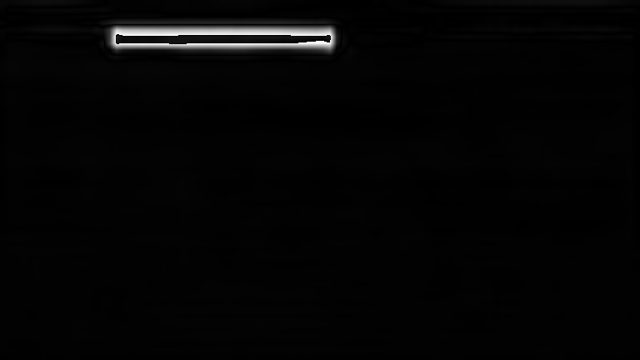

,width,height,area,fontsize,bbox,text,score
0,68.0,8.0,544.0,4.250000,"[4, 12, 312, 380]",powerpcint Slide,-0.004641
1,22.0,8.0,176.0,4.400000,"[4, 12, 384, 406]",snout,0.002207
2,40.0,8.0,320.0,4.444444,"[4, 12, 416, 456]",(Bias UUI,0.001331
3,261.0,24.0,6264.0,7.909091,"[35, 59, 137, 398]",Measuring osteoarthritis severity,0.854680
4,50.0,8.0,400.0,4.545455,"[62, 70, 640, 690]",Zud Gu4mcyc,0.008041


In [8]:
#### Now, we will apply finetuned DeepLab model and "score" each textbox as to whether it might be a title or not

out, scores = titlesegment(slide_, [ box['bbox'] for box in textboxes_ ])
out_mask = (np.abs(out.cpu().numpy())*255).astype(np.uint8)

textdata_['score'] = scores

display(f"Test slide #33 (segmentation output)", Image.fromarray(out_mask).resize((640,360)), textdata_.head(5))


In [9]:
# [''.join(re.findall(r'\d+', x)) for x in os.listdir('Test/Images')]

In [10]:
#### Iterate this method on all test images
from tqdm import tqdm

images = sorted(glob.glob('Test/Images/*.jpg'))
result = []

for path in tqdm(images):
    image = cv2.imread(path)
    textboxes = read_text(image)

    out, scores = titlesegment(image, [ box['bbox'] for box in textboxes ])
    titleboxes = pickonetitle(textboxes, scores)
    
    # Sort text boxes as you would read it in English: from top to bottom
    # and from left to right
    titleboxes = sort_boxes(titleboxes)
    title = ' '.join(box['text'] for box in titleboxes)    
    
    image_id = path.split("/")[-1] #int(''.join(re.findall(r'\d+', path.split('.')[0].split('/')[-1])))
    result.append([image_id, title])


#### Convert the result to a dataframe and save it

df = pd.DataFrame.from_records(result, columns=['ID','Title'])
df


100%|██████████| 290/290 [01:53<00:00,  2.56it/s]


,ID,Title
0,Id_06cra35n6n.jpg,Detect potential security threats
1,Id_08bjq60t4q.jpg,Chaofan Chen
2,Id_0g2lwbt3sa.jpg,Part 2: Convection DL instabilities & spurious...
3,Id_0h1arzmj2p.jpg,"Take any ""standard"" black box CNN:"
4,Id_0khgx7z8tk.jpg,Predict; prevent and detect insurance fraud
...,...,...
285,Id_zp77iny60p.jpg,Monitor environmental changes and measure ener...
286,Id_zrs2rtf33n.jpg,The Safe System Pillars
287,Id_zvhdc5e9ra.jpg,Stop explaining black box machine learning mod...
288,Id_zvhpkbv4rk.jpg,Interactive Machines


In [11]:
df.to_csv('Submission_deeplabv3_resnet101_epchs30.csv', index=False)